# О проекте
<a id='target100'></a>

Имеются два файла с результатами SQL запросов из предыдущих заданий. Проект тренировочный - требуется изучить данные, проверить данные на корректность, потренироваться с визуализацией.


### План:

1. [Знакомство с данными](#target1) 
2. [Города](#target2) 
3. [Самолёты](#target3)
4. [Резюме](#target4)

## Знакомство с данными 
<a id='target1'></a>

In [1]:
import pandas as pd
import numpy as np 
from IPython.display import display
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup as BS
from concurrent.futures import ThreadPoolExecutor, as_completed
try:
    from mpl_toolkits.basemap import Basemap
    reviewer_is_pepared = True
except:
    reviewer_is_pepared = False

In [2]:
plane = pd.read_csv('datasets/query_1.csv')
city = pd.read_csv('datasets/query_3.csv')
print('\nТаблицы (первая - целиком, от второй - 8 первых записей):')
display(plane)
display(city.head(8))
print('\nИнформация о таблицах:\n')
[display(df.info()) for df in [city, plane]];


Таблицы (первая - целиком, от второй - 8 первых записей):


,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613
5,Барнаул,2.612903
6,Белгород,6.000000
7,Белоярский,2.000000



Информация о таблицах:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             101 non-null    object 
 1   average_flights  101 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   model           8 non-null      object
 1   flights_amount  8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 160.0+ bytes


None

Повторяющихся самолётов нет. Названия городов упорядочены по алфавиту. Пропусков нет.

In [3]:
city['city'].is_unique

True

Повторяющихся городов нет.

In [4]:
print(f'В месяц по стране совершается ~{int(city.average_flights.sum() * 30)} полётов')
print(f'Рассматриваемые модели самолётов в месяц выполняют ~{plane.flights_amount.sum()} полётов')

В месяц по стране совершается ~16647 полётов
Рассматриваемые модели самолётов в месяц выполняют ~16285 полётов


Цифры в таблицах 'plane' и 'city' согласуются. 

## Города
<a id='target2'></a>

Изучим таблицу 'city'

Характистики переменной 'average_flights':


count    101.000000
mean       5.494189
std       13.119790
min        1.000000
25%        2.000000
50%        3.000000
75%        5.870968
max      129.774194
Name: average_flights, dtype: float64

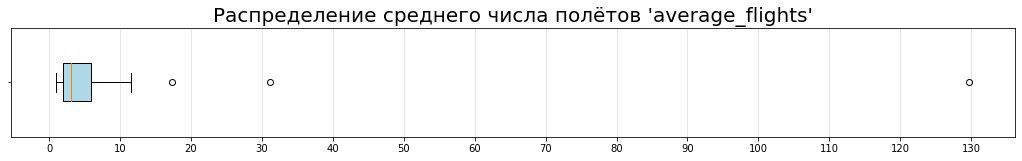

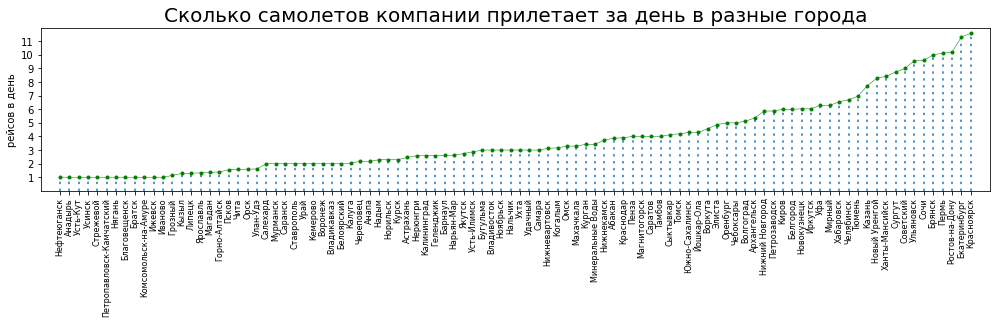

In [13]:
# таблица describe
print("Характистики переменной 'average_flights':")
display(city['average_flights'].describe())
print('\n')

# боксплот
plt.figure(figsize = (18,2))
plt.title("Распределение среднего числа полётов 'average_flights'", size = 20)
bx = plt.boxplot(city['average_flights'], vert = False, widths = 0.35, patch_artist = True)
bx['boxes'][0].set_facecolor('lightblue')
plt.gca().set_yticklabels([''])
plt.gca().set_xticks(np.arange(0, 140, 10))
plt.grid(b = True, axis = 'x', alpha = 0.4);
plt.show()

# график с точкой для каждого города
arr = city.loc[ city['average_flights'] <= 12 ].sort_values(by = 'average_flights')
seq = np.arange(1, len(arr) + 1)
fig, ax = plt.subplots(figsize = (17, 3), subplot_kw = {'ylim': (0, 12), 'xlim': (-1, len(arr) + 2),
                                                        'xticks': seq, 'yticks': np.arange(1, 12, 1),
                                                        'ylabel': 'рейсов в день'})
ax.set_title('Сколько самолетов компании прилетает за день в разные города', fontsize = 20)
ax.plot(seq, arr.average_flights.values, color = 'green', marker = '.', linestyle = '-', linewidth = 0.5)
ax.set_xticklabels(arr.city, rotation = 'vertical', fontdict = {'fontsize': 8})
plt.rcParams['lines.dashed_pattern'] = [1.6, 3]
ax.vlines(seq, 0, arr.average_flights.values, linestyle = 'dashed')
display(fig)
plt.close(fig)

# таблица топ-10 и округляю 'average_flights' для наглядности
top_10 = city.sort_values(by = 'average_flights', ascending = False).set_index('city')[:10]
top_10.average_flights = top_10.average_flights.apply(round, args = (0,)).apply(int)

Города, куда не прилетают самолеты, не включены в таблицу (min = 1). Судя по медиане, в большинство из данных городов за день прибывает не больше трёх самолётов. Высокие показатели среднего (mean) и стандартного отклонения обеспечены, прежде всего, Москвой и Санкт-Петербургом. Но и помимо выбросов, размах правой половины значений (тех что больше медианы) значительно выше, чем размах левой (следует из длины коробки и длины уса). Так что распределение не претендует на нормальный вид.

Попробуем нанести на карту в виде точек разного размера города, куда совершаются рейсы компании U9. 
Получить координаты городов получить при помощи API Яндекса 'Геокодер'. А чтобы ускорить обработку ответов на GET-запросы, реализуем многопоточность с помощью библиотеки 'concurrent.futures'.

In [6]:
# готовлю парсер
api_url = 'https://geocode-maps.yandex.ru/1.x/?apikey=7875154e-f59c-41cb-950e-69862cbae64a&results=1&format=json&geocode='
longitudes = {}
latitudes = {}
def submit_a_request(city_name):
    url = api_url + city_name.replace(' ', '+')
    response = requests.get(url).json()
    return city_name, response

# создаю экземляр ThreadPoolExecutor, запускаю парсер 
with ThreadPoolExecutor(5) as pool:    
    list_of_futures = [pool.submit(submit_a_request, city) for city in city.city.values]
    for future_object in as_completed(list_of_futures):
        city_name, response = future_object.result()
        longitude, latitude = (response['response']['GeoObjectCollection']['featureMember'][0]
                               ['GeoObject']['Point']['pos'].split())
        longitudes.update({city_name: longitude})
        latitudes.update({city_name: latitude})
        
# заношу координаты в таблицу
city['longitude'] = city['city'].map(longitudes)
city['latitude'] = city['city'].map(latitudes)
        
# вручную присваиваю числа - размеры точек на карте
def dot_size(flights):
    if flights <= 3:
        return 60
    elif flights <= 6.5:
        return 120
    elif flights <= 9.58:
        return 250
    else:
        return 350
city['dot_size'] = city['average_flights'].apply(dot_size)

Выведем несколько значений, чтобы убедиться, что всё сделано верно.

In [7]:
city.set_index('city').sample(3)

,average_flights,longitude,latitude,dot_size
city,,,,
Оренбург,5.000000,55.096955,51.768199,120
Красноярск,11.580645,92.852572,56.010563,350
Бугульма,3.000000,52.789489,54.536413,60


Продолжим рисовать карту.

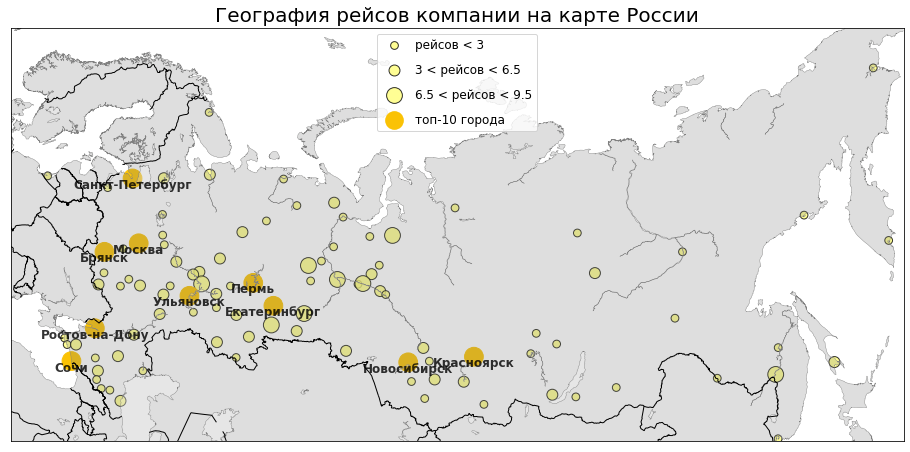

,average_flights
city,
Москва,130
Санкт-Петербург,31
Новосибирск,17
Красноярск,12
Екатеринбург,11
Ростов-на-Дону,10
Пермь,10
Брянск,10
Сочи,10


In [8]:
if reviewer_is_pepared:
    # два подзапроса: города в топ-10 и остальные города
    top_10_names = top_10.index
    top_10_t = city[ city.city.isin(top_10_names) ]
    city_t = city[ ~city.city.isin(top_10_names) ]

    # создание карты
    plt.figure(figsize = (16, 12))
    plt.title('География рейсов компании на карте России', fontsize = 20)
    geo_map = Basemap(projection = 'eqdc', lat_0 = 40, lon_0 = 95,
                      llcrnrlon = 39.418, llcrnrlat = 34.5,
                      urcrnrlon = -173.222, urcrnrlat = 64.5,
                      resolution = 'i', area_thresh = 1000.0)
    geo_map.drawcoastlines(linewidth = 0.4, color = 'grey')
    geo_map.fillcontinents(color = '#7d7f7c', alpha = 0.25)
    geo_map.drawcountries(linewidth = 1)

    # scatter plot: остальные города
    x, y = geo_map(city_t['longitude'].values, city_t['latitude'].values)
    geo_map.scatter(x, y, city_t['dot_size'].values, c = '#fffe7a', alpha = 0.8, linewidths = 1, edgecolors = 'black')

    # scatter plot: города из топ-10
    x, y = geo_map(top_10_t['longitude'].values, top_10_t['latitude'].values)
    geo_map.scatter(x, y, top_10_t['dot_size'].values, c = '#fac205', alpha = 1)
    for x, y, s in zip(x, y, top_10_t.city.values):
        plt.text(x, y - 5, s, fontsize = 12, ha = 'center', va = 'top', weight = 'demibold', alpha = 0.8)

    # добавление легенды
    inscrs = ['рейсов < 3', '3 < рейсов < 6.5', '6.5 < рейсов < 9.5', 'топ-10 города']
    for size, color, inscr, alpha, wid in zip([60, 120, 250, 350], 
                                              ['#fffe7a', '#fffe7a', '#fffe7a', '#fac205'], 
                                              inscrs, [0.8, 0.8, 0.8, 1], [1, 1, 1, 0]):
        plt.scatter([], [], size, c = color, label = inscr, alpha = alpha, linewidths = wid, edgecolors = 'black')
    plt.legend(scatterpoints = 1, labelspacing = 1, loc = 'upper center', fontsize = 'large')
    
    # вывод рисунка и таблицы 'top_10'
    plt.show()
    plt.close()
    display(top_10)
else:
    print('Рисунок можно посмотреть по адресу\nhttp://joxi.ru/vAWEzNvCOQ7kVm\n')
    display(top_10)

Нетрудно заметить, что авиакомпания ведёт активную деятельность в Приволжье, на юге России и, в особенности, на Урале. В Центральную Россию, если опустить Москву и Санкт-Петербург, совершается относительно мало рейсов. Можно предположить, что компания специализируется на региональных перевозках.

## Самолёты
<a id='target3'></a>

Изучим таблицу 'planes'

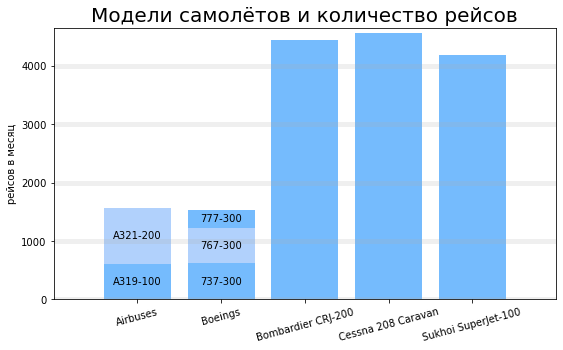

,flights_amount
group,
Airbuses,1567
Boeings,1530
Bombardier CRJ-200,4446
Cessna 208 Caravan,4557
Sukhoi SuperJet-100,4185


In [9]:
# объединяю по группам самолёты одного производителя
def grouping(name):
    if 'Airbus' in name:
        return 'Airbuses'
    elif 'Boeing' in name:
        return 'Boeings'
    return name
plane['group'] = plane.model.apply(grouping)

# готовлю три отдельные таблицы для столбчатого графика
airbuses = plane[ plane['group'] == 'Airbuses' ].copy()
airbuses.loc[:, 'cumsum'] = airbuses.loc[:, 'flights_amount'].cumsum()
boeings = plane[ plane['group'] == 'Boeings' ].copy()
boeings.loc[:, 'cumsum'] = boeings.loc[:, 'flights_amount'].cumsum()
others = plane[ ~plane['group'].isin(('Airbuses', 'Boeings')) ]

# настраиваю оси графика
fig, ax_models = plt.subplots(figsize = (9, 5), subplot_kw = {'xlim': (0, len(plane['group'].unique()) + 1), 
                                                              'xticks': np.arange(1, len(plane['group'].unique()) + 1),
                                                              'ylim': (0, 4650)})
ax_models.set_xticklabels(plane['group'].unique(), rotation = 15)
ax_models.grid(b = True, axis = 'y', alpha = 0.2, linewidth = 5)
ax_models.set_ylabel('рейсов в месяц')
ax_models.set_title('Модели самолётов и количество рейсов', fontsize = 20)

# первый столбец Airbuses
for (model_name, count, _, cumsum), col in zip(airbuses.values, ['#75bbfd', '#b1d1fc']):
    model_name = model_name.split(' ')[1]
    ax_models.bar(1, count, bottom = cumsum - count, color = col, width = 0.8)
    ax_models.text(1, (cumsum - count) + count / 2, model_name, ha = 'center', va = 'center')
    
# второй столбец Boeings
for (model_name, count, _, cumsum), col in zip(boeings.values, ['#75bbfd', '#b1d1fc', '#75bbfd']):
    model_name = model_name.split(' ')[1]
    ax_models.bar(2, count, bottom = cumsum - count, color = col, width = 0.8)
    ax_models.text(2, (cumsum - count) + count / 2, model_name, ha = 'center', va = 'center')
    
# остальные столбцы и вывод рисунка
ax_models.bar([3, 4, 5], others['flights_amount'], color = '#75bbfd', width = 0.8)
display(fig)
plt.close(fig)

# вывожу таблицу с количеством рейсов
display(plane.groupby(plane['group']).agg({'flights_amount': 'sum'}))

Самолёты Airbus и Boeing компании F9 по стране летают чаще, чем самолёты Cessna и Bombardier. Но последние два относятся к семейству региональных самолётов, рассчитанных на небольшое число пассажиров и короткие перелёты. А вот модели Airbus, Boeing и Sukhoi SuperJet-100 относятся к одному классу магистральных самолётов. В парке F9 Sukhoi SuperJet-100 используются активнее.

## Резюме
<a id='target4'></a>

Исследовав файлы, мы выяснили, что:
- данные не нуждаются в предобработке
- число рейсов распределено ассиметрично, есть "выбросы"
- авиакомпания активно действует на юге России, на Урале и в Приволжье
- флот авиакомпании рассчитан на региональные перевозки

[К началу](#target100) 